In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler


sstyle = 'seaborn-v0_8-poster'
plt.style.use(sstyle)
plt.rc('font',family = 'serif')


pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

# ENTROPY VARIABLES | All classifiers | Small Dataset

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.9998.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

9.88% of the data decreased alpha_R
90.12% of the data did not decrease alpha_R


In [4]:
plasma_characteristics = ["Q95","BEIMHD","PREMAG",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI","PNBI"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 

features = plasma_characteristics + TOK_characteristics + ELM + \
           heating + impurities + power + temperatures + fast_particles

In [9]:
len(features)

47

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [6]:
lr = LogisticRegression(n_jobs=-1, random_state=71)
lr.fit(X_train, y_train)
y_pred_lr= lr.predict_proba(X_test)
y_pred_lr = y_pred_lr[:, 1]
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_pred_lr)


# Accuracy
print("\n Logistic Regression")
print(f"Training Accuracy: {round(lr.score(X_train,y_train), 2)}")
print(f"Test Accuracy: {round(lr.score(X_test,y_test), 2)}")
# -----------------------------------------------------------------

gp = GaussianProcessClassifier(n_jobs=-1, random_state=71)
gp.fit(X_train, y_train)
y_pred_gp= gp.predict_proba(X_test)
y_pred_gp = y_pred_gp[:, 1]
precision_gp, recall_gp, thresholds_gp = precision_recall_curve(y_test, y_pred_gp)


# Accuracy
print("\n Gaussian Process")
print(f"Training Accuracy: {round(gp.score(X_train,y_train), 2)}")
print(f"Test Accuracy: {round(gp.score(X_test,y_test), 2)}")
# -----------------------------------------------------------------

rf = RandomForestClassifier(n_jobs=-1, random_state=71)
rf.fit(X_train, y_train)
y_pred_rf= rf.predict_proba(X_test)
y_pred_rf = y_pred_rf[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)


# Accuracy
print("\n Random Forest")
print(f"Training Accuracy: {round(rf.score(X_train,y_train), 2)}")
print(f"Test Accuracy: {round(rf.score(X_test,y_test), 2)}")

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Logistic Regression
Training Accuracy: 0.9
Test Accuracy: 0.9

 Gaussian Process
Training Accuracy: 0.95
Test Accuracy: 0.88

 Random Forest
Training Accuracy: 1.0
Test Accuracy: 0.89


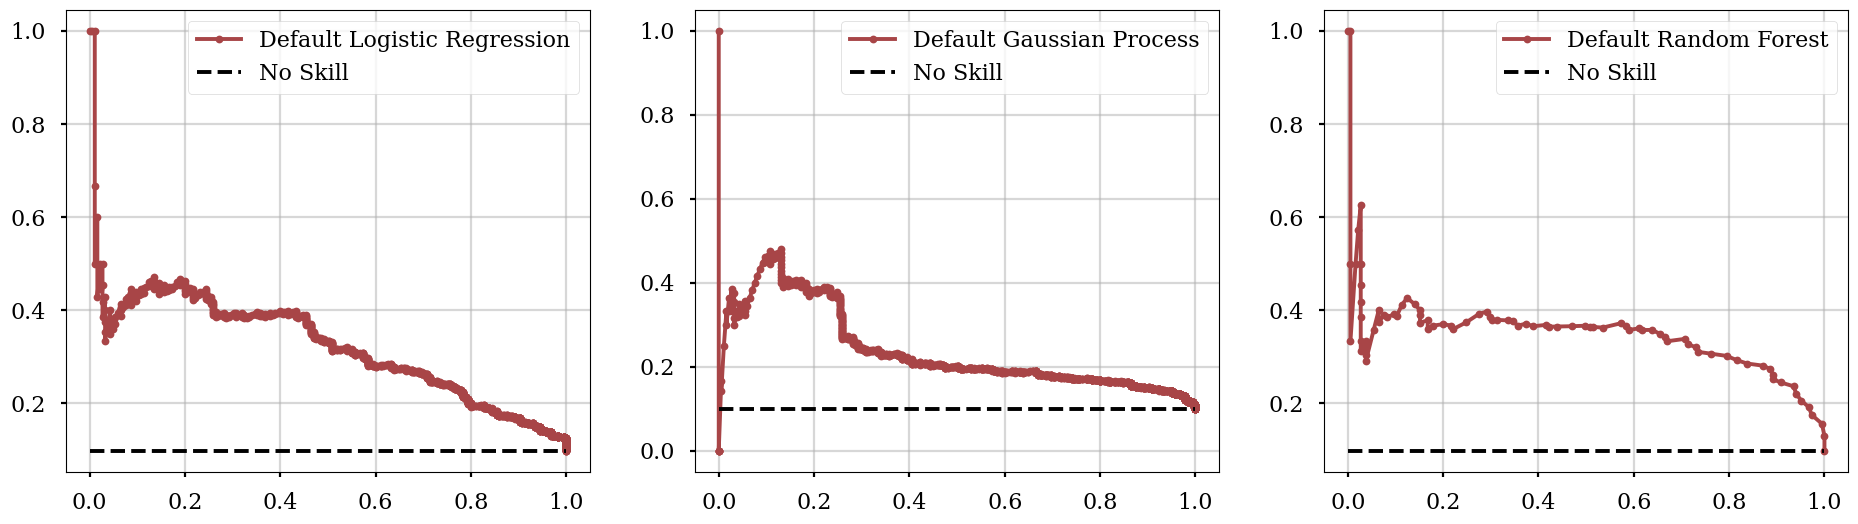

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23, 6))
no_skill = len(y_test[y_test==1]) / len(y_test)

axs[0].plot(recall_lr, precision_lr, marker='.', label='Default Logistic Regression', c="#A84547")
axs[0].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c="k")
axs[0].grid(alpha=0.5)
axs[0].legend(loc="upper right")

axs[1].plot(recall_gp, precision_gp, marker='.', label='Default Gaussian Process', c="#A84547")
axs[1].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c="k")
axs[1].grid(alpha=0.5)
axs[1].legend(loc="upper right")

axs[2].plot(recall_rf, precision_rf, marker='.', label='Default Random Forest', c="#A84547")
axs[2].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c="k")
axs[2].grid(alpha=0.5)
axs[2].legend(loc="upper right");

plt.savefig(fig_path+"simple_ROC_small_ds.pdf", format="pdf", dpi=800, bbox_inches='tight');

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_metrics_for_minority(model, X_test, y_test):

    predictions = model.predict(X_test)
    minority_mask = y_test == 1
    
    minority_true_labels = y_test[minority_mask]
    minority_predicted_labels = predictions[minority_mask]
    
    minority_accuracy  = np.round(accuracy_score(minority_true_labels, minority_predicted_labels), 2)
    minority_precision = np.round(precision_score(y_test, predictions, pos_label=1), 2)
    minority_recall    = np.round(recall_score(y_test, predictions, pos_label=1), 2)
    minority_f1score   = np.round(f1_score(y_test, predictions, pos_label=1), 2)
    print("Minority Class\n")
    print(f"Acc: {minority_accuracy},\nPre: {minority_precision},\nRec: {minority_recall},\nF1s: {minority_f1score}")


In [15]:
print("Report on: LOGISTIC REGRESSION")
get_metrics_for_minority(lr, X_test, y_test)

Report on: LOGISTIC REGRESSION
Minority Class

Acc: 0.1,
Pre: 0.42,
Rec: 0.1,
F1s: 0.16


In [16]:
print("Report on: GAUSSIAN PROCESS")
get_metrics_for_minority(gp, X_test, y_test)

Report on: GAUSSIAN PROCESS
Minority Class

Acc: 0.25,
Pre: 0.37,
Rec: 0.25,
F1s: 0.3


In [17]:
print("Report on: RANDOM FOREEST")
get_metrics_for_minority(rf, X_test, y_test)

Report on: RANDOM FOREEST
Minority Class

Acc: 0.2,
Pre: 0.37,
Rec: 0.2,
F1s: 0.26
